# 📱 Smartphone Price Prediction with Machine Learning

This project aims to predict smartphone prices using various hardware and software specifications. The objective is to build a regression model that can accurately estimate the price of a phone based on its specs.

This project will:
- Clean and preprocess the data
- Handle outliers
- Engineer useful features
- Train a Random Forest regression model
- Evaluate its performance using MAE, RMSE, and R²
- Visualize important feature relationships and model insights

For information on the data click [here.](https://www.kaggle.com/datasets/ankit07chy/mobile-uncleaned-data-set-scrapped-real-website/code)

In [226]:
#Necessary imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import re

Here I’m loading the dataset and taking a quick look at the columns and missing values to understand what I’m working with.

In [227]:
df = pd.read_csv('mobile.csv')
print(df.columns)
print(str(df.isna().sum()))

Index(['Name', 'Spec Score', 'rating', 'price', 'img', 'tag', 'sim',
       'processor', 'storage', 'battery', 'display', 'camera',
       'memoryExternal', 'version', 'fm'],
      dtype='object')
Name                0
Spec Score          0
rating              0
price               0
img                 0
tag                 0
sim                 0
processor          26
storage            20
battery             6
display             1
camera             11
memoryExternal    351
version            48
fm                725
dtype: int64


Now I'm going to go through the data and see if I can find any trends while cleaning all the data for the model/

The dataset had some columns like images and tags that can't be used in my implementation, so I removed them to keep things clean. I then look at the first few rows to better understand the data.

In [228]:
df = df.drop(['img', 'tag'], axis = 1)
print(df.head())

                  Name  Spec Score  rating  price  \
0  OPPO Reno 14 Pro 5G          89    4.65  41990   
1      OPPO Reno 14 5G          87    4.75  32990   
2           Poco F7 5G          83    4.75  31999   
3         Vivo X200 FE          89    4.65  49990   
4         OPPO K13x 5G          73    4.20  11999   

                                                 sim  \
0  Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC, IR Bl...   
1  Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC, IR Bl...   
2  Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC, IR Bl...   
3  Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC, IR Bl...   
4                 Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi   

                                           processor  \
0      Dimensity 8450, Octa Core, 3.25 GHz Processor   
1      Dimensity 8350, Octa Core, 3.35 GHz Processor   
2   Snapdragon 8s Gen4, Octa Core, 3.2 GHz Processor   
3  Dimensity 9300 Plus, Octa Core, 3.25 GHz Proce...   
4       Dimensity 6300, Octa Core, 2.4 GHz Processor   

       

I'm going to ensure that the numeric values **'Spec Score', 'rating', and 'price'** are stored numerically and convert the price from **INR(₹)** to **USD($)**

In [248]:
df['spec score'] = pd.to_numeric(df['Spec Score'], errors='coerce')
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['price_usd'] = df['price'] / 86

I took the first word from the phone's **name** column and saved it as a new column called **brand** in order to determine the most common brands.

In [270]:
#Clean 'name'
df['brand'] = df['Name'].fillna('').astype(str).str.split().str[0]

Now I'm going to visualize all the different brands and the amount with a bar plot.

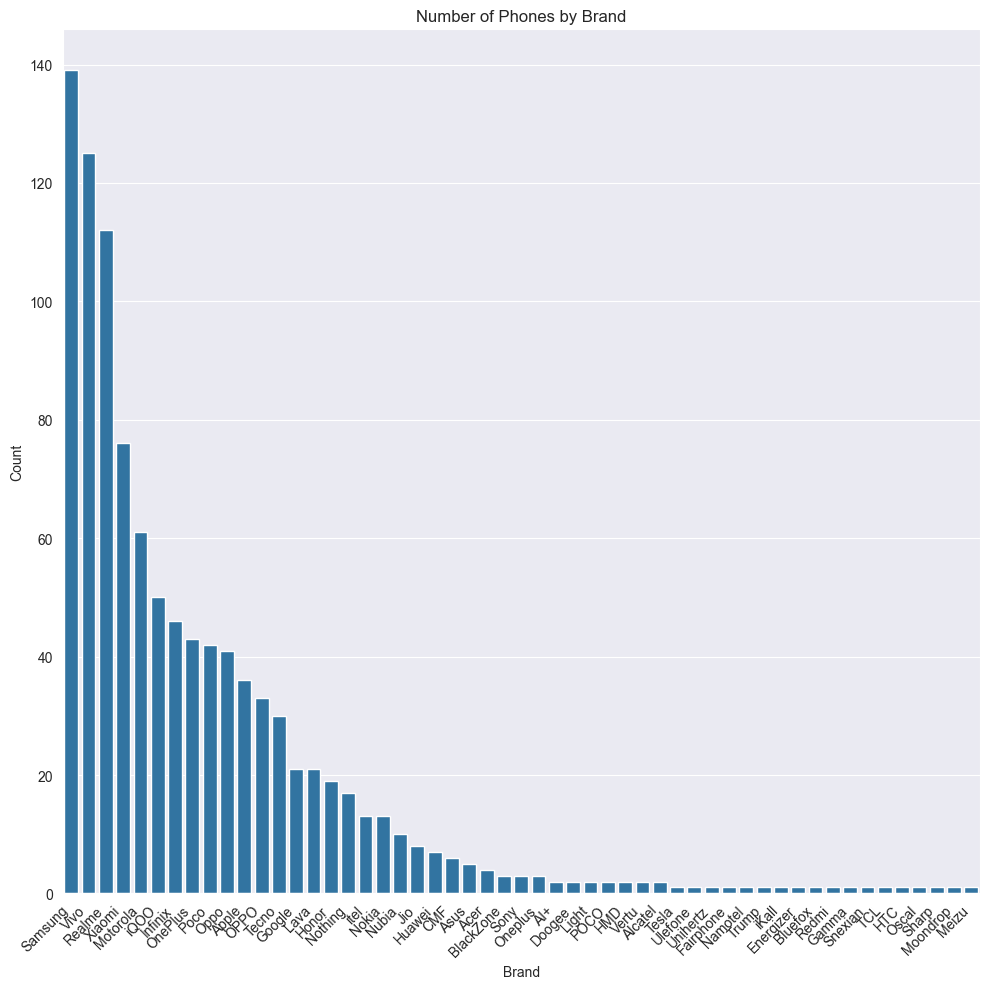

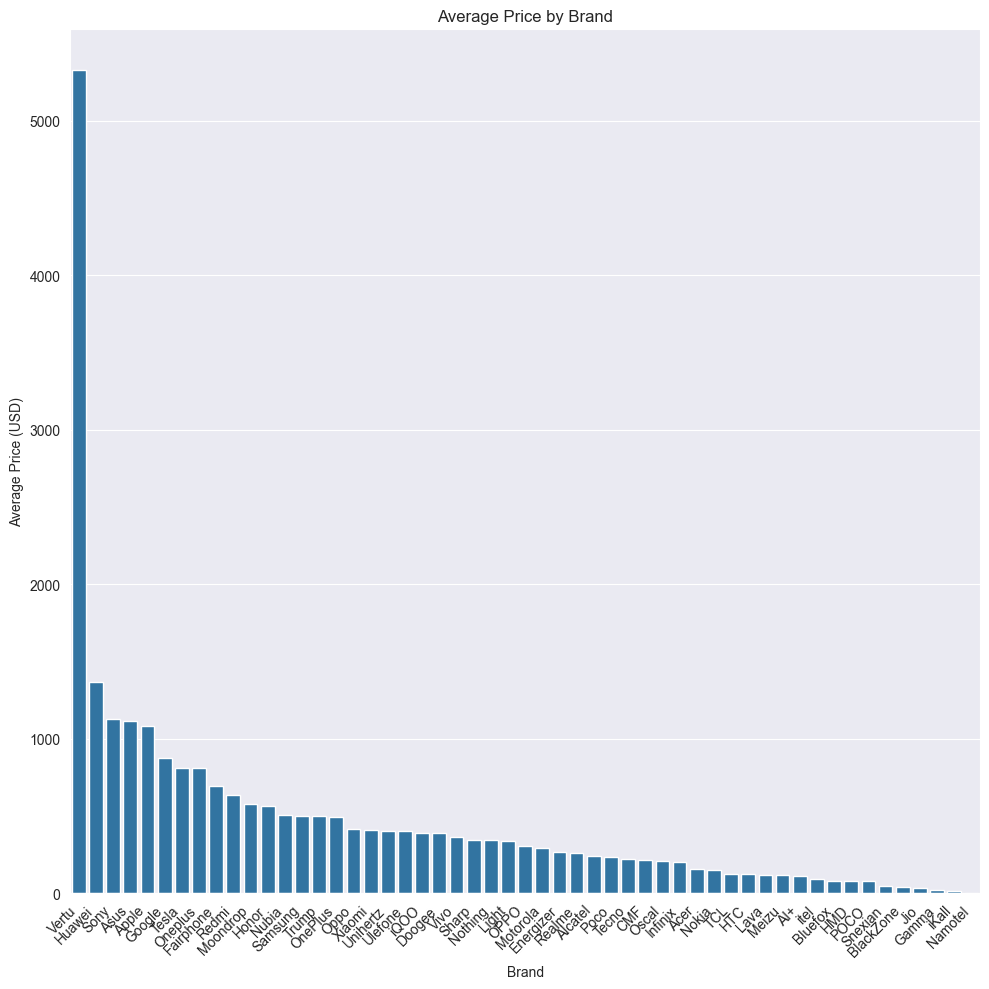

In [273]:
# Count amount per brand
brand_counts = df['brand'].value_counts().reset_index()
brand_counts.columns = ['brand', 'count']

# Plot amount by brand
plt.figure(figsize=(10, 10))
sns.barplot(data=brand_counts, x='brand', y='count')
plt.xticks(rotation=45, ha='right')
plt.title('Number of Phones by Brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Calculate mean price for each brand
brand_price_mean = df.groupby('brand')['price_usd'].mean().reset_index()
brand_price_mean = brand_price_mean.sort_values('price_usd', ascending=False)

# Plot mean price per brand
plt.figure(figsize=(10, 10))
sns.barplot(data=brand_price_mean, x='brand', y='price_usd')
plt.xticks(rotation=45, ha='right')
plt.title('Average Price by Brand')
plt.xlabel('Brand')
plt.ylabel('Average Price (USD)')
plt.tight_layout()
plt.show()


**Samsung** appears to have the highest number of phones available on the market.

The average phone price for each brand also appears to be under $1500; however, due the abnormally high average for **Ventu** and the lows for **Gamma, iKali, and Namotel**, there are likely statistical outliers in the prices that must be adjusted before creating the model.

The **sim** column contains a string describing the SIM capabilities of each phone. To simplify analysis and modeling, I converted this information into separate boolean features that indicate whether certain capabilities are present. This includes support for dual SIM, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC, IR blaster, and more.

In [230]:
df['sim'] = df['sim'].fillna('').str.lower()
df['no_sim'] = df['sim'].str.contains('no sim supported')
df['is_dual_sim'] = df['sim'].str.contains('dual')
df['has_3g'] = df['sim'].str.contains('3g')
df['has_4g'] = df['sim'].str.contains('4g')
df['has_5g'] = df['sim'].str.contains('5g')
df['has_volte'] = df['sim'].str.contains('volte')
df['has_vo5g'] = df['sim'].str.contains('vo5g')
df['has_wifi'] = df['sim'].str.contains('wi-fi')
df['has_nfc'] = df['sim'].str.contains('nfc')
df['has_ir_blaster'] = df['sim'].str.contains('ir blaster')

Next, I’ll show how common each SIM-related feature is among the phones in the dataset using bar plots.

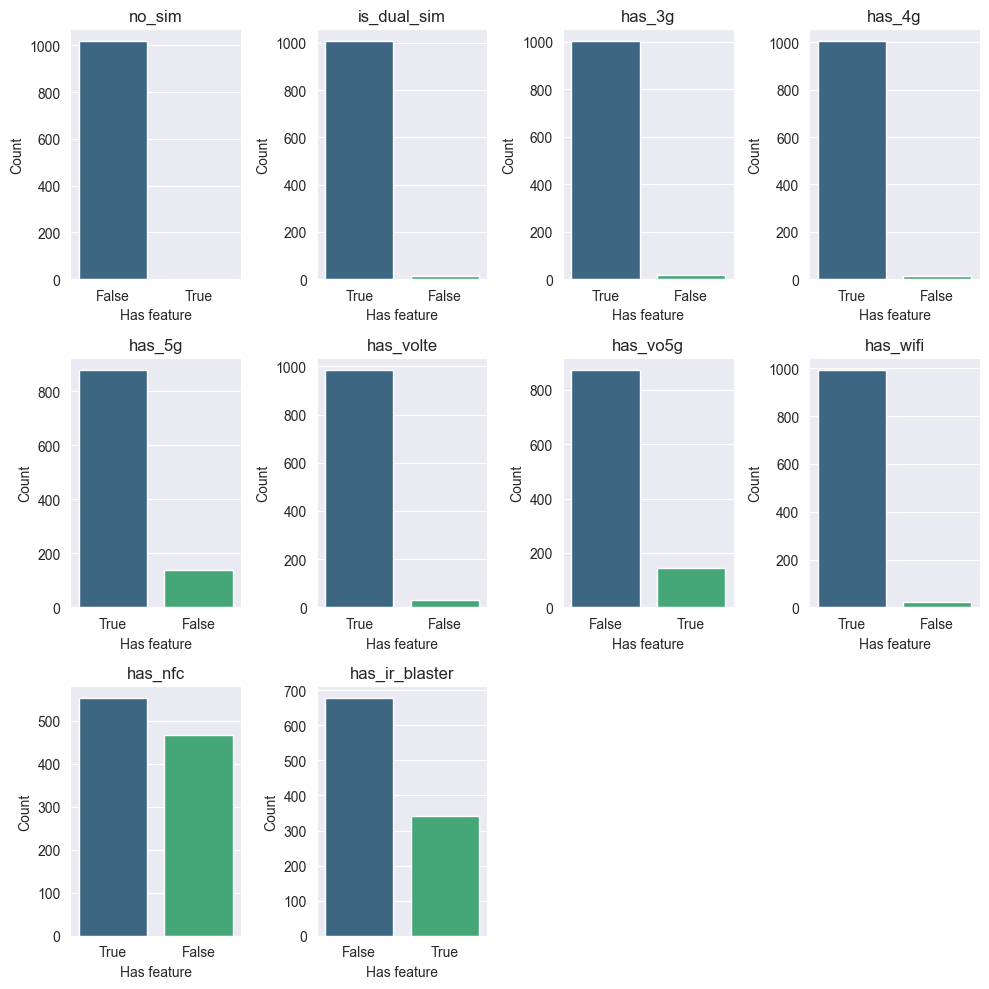

In [231]:

# List of sim feature columns (boolean)
sim_features = [
    'no_sim', 'is_dual_sim', 'has_3g', 'has_4g', 'has_5g',
    'has_volte', 'has_vo5g', 'has_wifi', 'has_nfc', 'has_ir_blaster'
]

plt.figure(figsize=(10, 10))
for i, col in enumerate(sim_features, 1):
    plt.subplot(3, 4, i)  # 3 rows, 4 columns grid
    counts = df[col].value_counts(dropna=False)
    sns.barplot(x=counts.index.astype(str), y=counts.values, hue=counts.index.astype(str), palette="viridis", legend=False)
    plt.title(col)
    plt.xlabel('Has feature')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

From these bar plots we can extract quite a few details about phones on the market:
- Every phone has some sort of sim
- Nearly all phones support dual SIM, 3G, 4G, VoLTE, and Wi-Fi connectivity
- Most phones support 5G
- The majority of phones lack support for Vo5G and do not have an IR blaster
- The number of phones with NFC is almost evenly split, with a slight majority supporting it.

Extracted processor brand, speed (in GHz), and core count from the raw **processor** description by parsing text and mapping core type words to numeric values for easier analysis.

In [232]:
# Clean 'processor' column by filling NaNs and converting to lowercase
df['processor_clean'] = df['processor'].fillna('').str.lower()

# Extract processor brand (e.g., 'qualcomm snapdragon')
df['processor_brand'] = df['processor_clean'].str.extract(r'^([a-z0-9]+(?:\s+[a-z0-9]+)?)')

# Extract processor speed in GHz as a float
df['processor_speed_ghz'] = df['processor_clean'].str.extract(r'([\d.]+)\s*ghz').astype(float)

# Map core type words to numeric values
core_map = {
    'single': 1,
    'dual': 2,
    'tri': 3,
    'quad': 4,
    'penta': 5,
    'hexa': 6,
    'septa': 7,
    'octa': 8,
    'nona': 9,
    'deca': 10
}

# Extract core type word from processor string
df['core_type'] = df['processor_clean'].str.extract(r'(single|dual|tri|quad|penta|hexa|octa|deca)')

# Map core type words to corresponding core counts
df['core_count'] = df['core_type'].map(core_map)

# Remove temporary columns used for extraction
df.drop(columns=['processor_clean', 'core_type'], inplace=True)

Visualized processor characteristics: top brands by count, distribution of processor speeds, and the frequency of different core counts in the dataset.

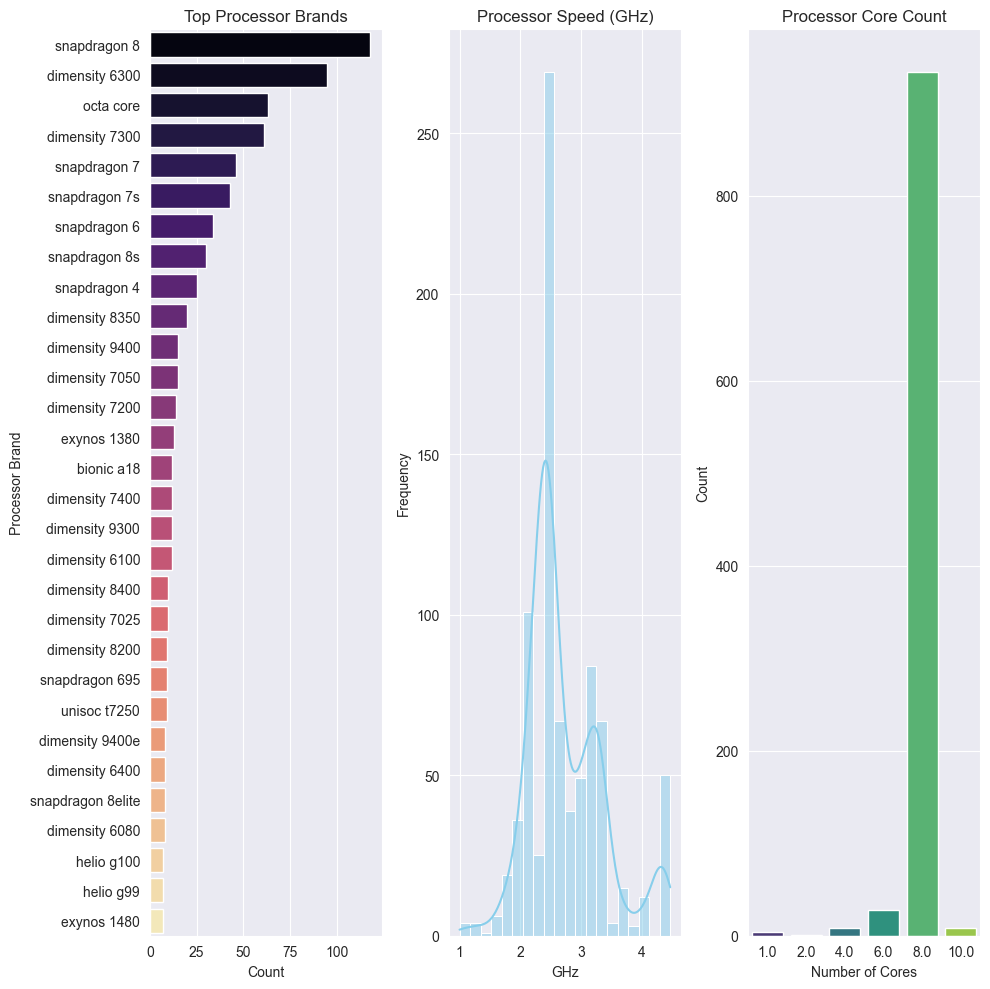

In [277]:
plt.figure(figsize=(10, 10))  # Adjusted width for 3 plots side by side

# Processor Brand - categorical bar plot (top 30 brands)
plt.subplot(1, 3, 1)
brand_counts = df['processor_brand'].value_counts().head(30)
sns.barplot(x=brand_counts.values, y=brand_counts.index, hue=brand_counts.index, palette="magma", legend=False)
plt.title('Top Processor Brands')
plt.xlabel('Count')
plt.ylabel('Processor Brand')

# Processor Speed (GHz) - numeric distribution
plt.subplot(1, 3, 2)
sns.histplot(df['processor_speed_ghz'].dropna(), bins=20, kde=True, color='skyblue')
plt.title('Processor Speed (GHz)')
plt.xlabel('GHz')
plt.ylabel('Frequency')

# Core Count - categorical bar plot
plt.subplot(1, 3, 3)
core_counts = df['core_count'].value_counts().sort_index()
sns.barplot(x=core_counts.index.astype(str), y=core_counts.values, hue=core_counts.index.astype(str), palette="viridis", legend=False)
plt.title('Processor Core Count')
plt.xlabel('Number of Cores')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

- Snapdragon appears to have a solid hold on the CPU market as it dominates in the top 30 CPUs
- Most processors appear to be ~2.5 GHz
- Most mobile devices have 8 cores

The battery information was cleaned and parsed to extract two key numeric features: battery capacity (in mAh) and charging speed (in watts).

In [234]:
df['battery'] = df['battery'].fillna('').astype(str).str.lower()

df['battery_capacity_mah'] = df['battery'].str.extract(r'(\d+)\s*mah').astype(float)

df['charging_speed_w'] = df['battery'].str.extract(r'(\d+)\s*w').astype(float)

Histograms to visualize battery capacity and charging speed.

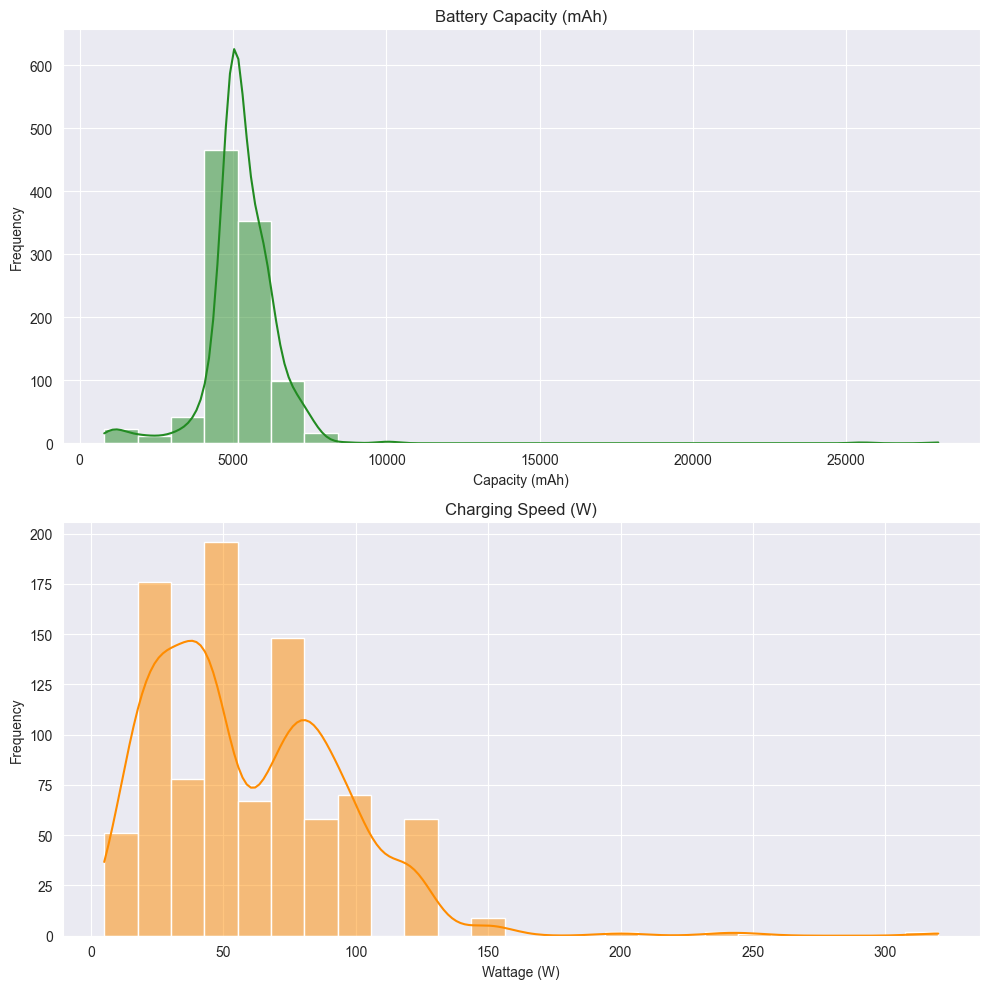

In [278]:
plt.figure(figsize=(10, 10))

# Battery Capacity - numeric histogram
plt.subplot(2, 1, 1)
sns.histplot(df['battery_capacity_mah'].dropna(), bins=25, kde=True, color='forestgreen')
plt.title('Battery Capacity (mAh)')
plt.xlabel('Capacity (mAh)')
plt.ylabel('Frequency')

# Charging Speed - numeric histogram
plt.subplot(2, 1, 2)
sns.histplot(df['charging_speed_w'].dropna(), bins=25, kde=True, color='darkorange')
plt.title('Charging Speed (W)')
plt.xlabel('Wattage (W)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

- Most batteries have a capacity ~5000 mAh
- Charging speed seems to be within 20-80 W
- The right skew indicates that there may be outliers in the data

Cleans the **display** specifications by extracting features such as screen size (in inches), resolution, refresh rate (in Hz), and display type from the raw display text.

In [236]:
#Clean 'display'
df['display_clean'] = df['display'].fillna('').astype(str)
df['screen_size_inches'] = df['display_clean'].str.extract(r'(\d+(?:\.\d+)?)\s*inches').astype(float)
df['resolution'] = df['display_clean'].str.extract(r'(\d+\s*[×x]\s*\d+)\s*px')
df['resolution'] = df['resolution'].str.replace('×', 'x').str.replace(' ', '')
df['refresh_rate_hz'] = df['display_clean'].str.extract(r'(\d+)\s*Hz').astype(float)
df['display_type'] = df['display_clean'].str.extract(r'with\s+(.+)', expand=False)
df.drop(columns='display_clean', inplace=True)


Visualize key display features of the phones: the distribution of screen sizes, the most common screen resolutions, refresh rates, and display panel types.

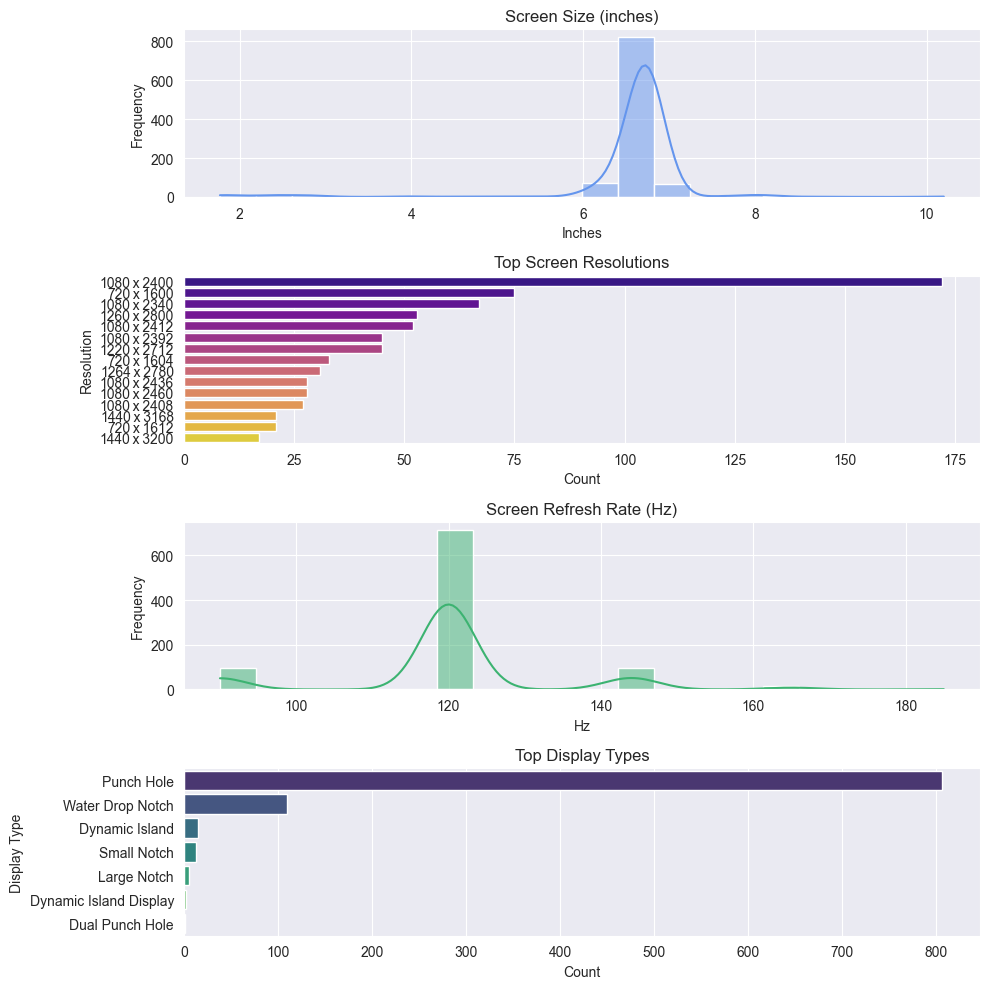

In [237]:
plt.figure(figsize=(10, 10))

# 1. Screen Size (inches)
plt.subplot(4, 1, 1)
sns.histplot(df['screen_size_inches'].dropna(), bins=20, kde=True, color='cornflowerblue')
plt.title('Screen Size (inches)')
plt.xlabel('Inches')
plt.ylabel('Frequency')

# 2. Resolution (top 15 most common)
plt.subplot(4, 1, 2)
res_counts = df['resolution'].value_counts().head(15)
sns.barplot(x=res_counts.values, y=res_counts.index, hue=res_counts.index, legend=False, palette="plasma")
plt.title('Top Screen Resolutions')
plt.xlabel('Count')
plt.ylabel('Resolution')

# 3. Refresh Rate (Hz)
plt.subplot(4, 1, 3)
sns.histplot(df['refresh_rate_hz'].dropna(), bins=20, kde=True, color='mediumseagreen')
plt.title('Screen Refresh Rate (Hz)')
plt.xlabel('Hz')
plt.ylabel('Frequency')

# 4. Display Type
plt.subplot(4, 1, 4)
type_counts = df['display_type'].value_counts()
sns.barplot(x=type_counts.values, y=type_counts.index, hue=type_counts.index, legend=False, palette="viridis")
plt.title('Top Display Types')
plt.xlabel('Count')
plt.ylabel('Display Type')

plt.tight_layout()
plt.show()

- Most phones have a screen size of ~7 inches
- Many phones appear to be 1080 X 2400, but there are still quite a few phones with smaller displays
- Most refresh rates are 120 with a few weaker and a few stronger
- Most phones have a **Punch hole** display type

I cleaned the **camera** column by splitting it into rear and front camera details, then extracted the megapixels and number of lenses for the rear cameras, as well as the front camera megapixels, to better analyze camera specifications.

In [238]:
df['camera'] = df['camera'].fillna('').astype(str).str.lower()

split_camera = df['camera'].str.split(r'\s*&\s*', n=1, expand=True)
df['rear_text'] = split_camera[0]
df['front_text'] = split_camera[1].fillna('')

df['rear_mp_list'] = df['rear_text'].apply(lambda x: list(map(int, re.findall(r'(\d+)\s*mp', x))))
df['rear_mp_total'] = df['rear_mp_list'].apply(sum)
df['rear_lens_count'] = df['rear_mp_list'].apply(len)

lens_word_map = {
    'single': 1,
    'dual': 2,
    'triple': 3,
    'quad': 4,
    'penta': 5,
    'hexa': 6
}

df['rear_lens_word'] = df['rear_text'].str.extract(r'\b(single|dual|triple|quad|penta|hexa)\b')[0]
df['rear_lens_word_count'] = df['rear_lens_word'].map(lens_word_map)

df['front_mp'] = df['front_text'].str.extract(r'(\d+)\s*mp')[0].astype(float)

df.drop(columns=['rear_text', 'front_text'], inplace=True)

Create three plots to explore the camera features: the distribution of individual rear camera megapixels, the distribution of front camera megapixels, and a bar plot showing how many rear lenses phones typically have.

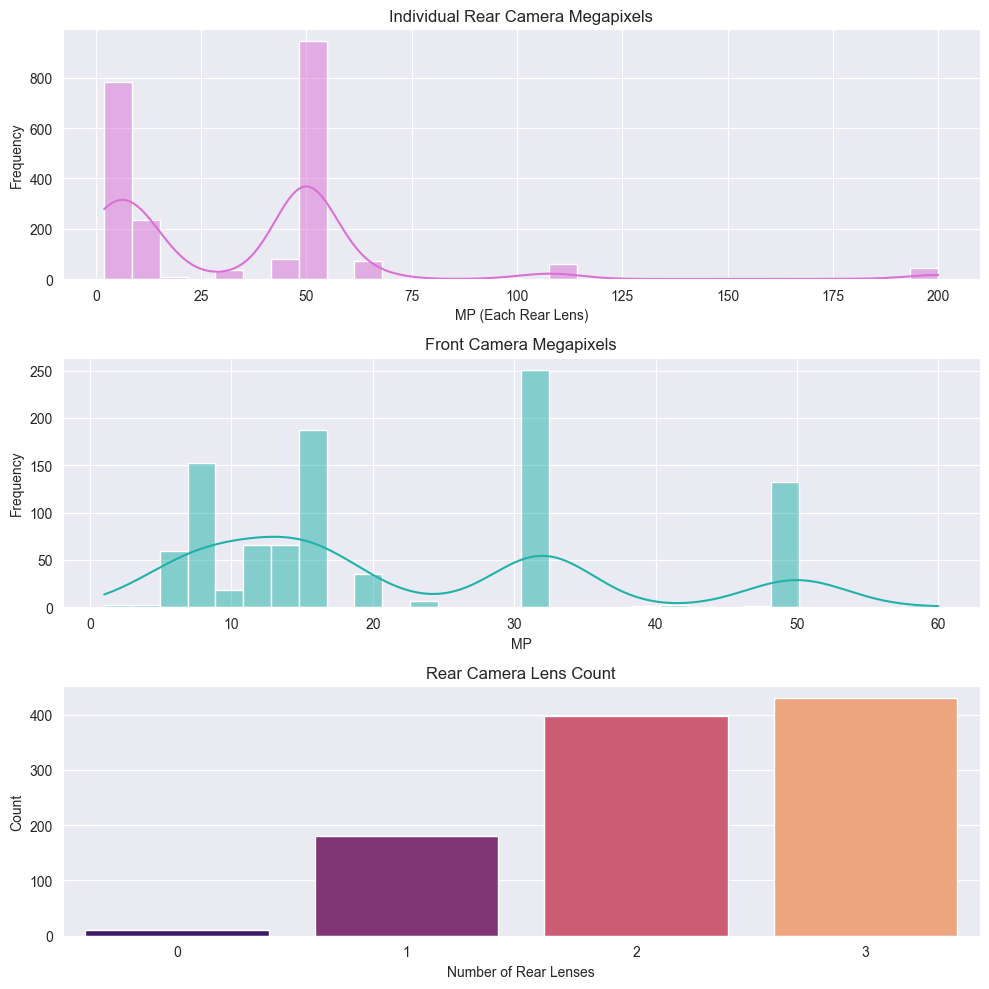

In [279]:
plt.figure(figsize=(10, 10))

# 1. Individual Rear Camera MPs (flattened list)
plt.subplot(3, 1, 1)
rear_individual_mps = df['rear_mp_list'].explode().dropna().astype(int)
sns.histplot(rear_individual_mps, bins=30, kde=True, color='orchid')
plt.title('Individual Rear Camera Megapixels')
plt.xlabel('MP (Each Rear Lens)')
plt.ylabel('Frequency')

# 2. Front Camera MPs
plt.subplot(3, 1, 2)
sns.histplot(df['front_mp'].dropna(), bins=30, kde=True, color='lightseagreen')
plt.title('Front Camera Megapixels')
plt.xlabel('MP')
plt.ylabel('Frequency')

# 3. Number of Rear Lenses
plt.subplot(3, 1, 3)
lens_counts = df['rear_lens_count'].value_counts().sort_index()
sns.barplot(x=lens_counts.index.astype(str), y=lens_counts.values, hue=lens_counts.index.astype(str), palette="magma", legend=False)
plt.title('Rear Camera Lens Count')
plt.xlabel('Number of Rear Lenses')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

- As most NAs were converted to 0, most rear cameras are 50 Megapixels
- The front cameras are a lot more varied but appear to mainly be ~30 Megapixels
- Most phones have 2-3 rear cameras

Extracts the maximum external memory size from the **memoryExternal** column, ensures it is in gigabytes, and creates a new column to show if external memory is supported.

In [240]:
df['memoryExternal'] = df['memoryExternal'].fillna('').astype(str).str.lower()

df[['external_memory_size', 'external_memory_unit']] = df['memoryExternal'].str.extract(r'upto\s*(\d+)\s*(gb|tb)')

df['external_memory_gb'] = df.apply(
    lambda row: float(row['external_memory_size']) * (1024 if row['external_memory_unit'] == 'tb' else 1)
    if pd.notnull(row['external_memory_size']) else None,
    axis=1
)

df['external_memory_supported'] = df['external_memory_gb'].notnull() & (df['external_memory_gb'] > 0)

df.drop(columns=['external_memory_size', 'external_memory_unit'], inplace=True)

Visualizes external memory support and capacity distribution. The first plot shows how many devices support external memory cards, while the second shows the distribution of external memory sizes in gigabytes, with 0 indicating no support or missing values.

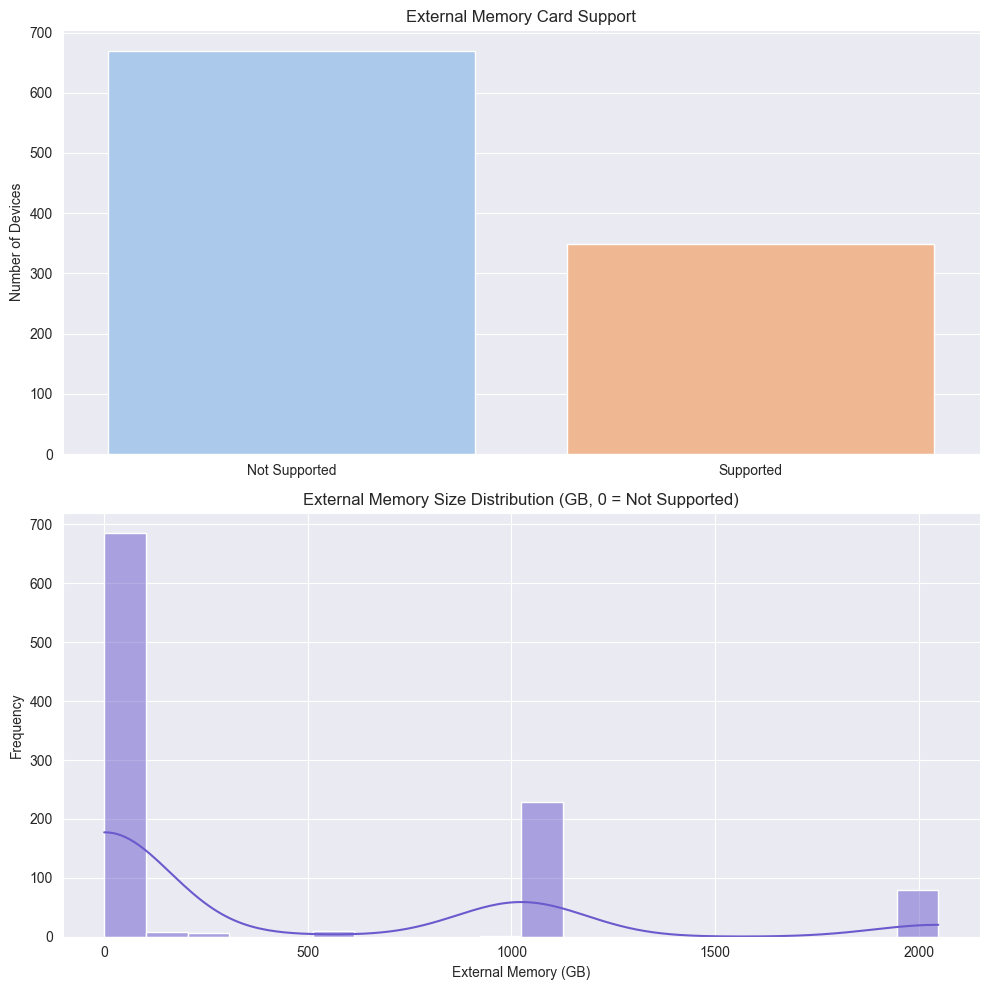

In [241]:
df['external_memory_gb_filled'] = df['external_memory_gb'].fillna(0)

support_counts = df['external_memory_supported'].value_counts()

plt.figure(figsize=(10, 10))

# 1. External Memory Support - Bar Plot
plt.subplot(2, 1, 1)
sns.barplot(
    x=support_counts.index.map({True: 'Supported', False: 'Not Supported'}),
    y=support_counts.values,
    hue=support_counts.index.map({True: 'Supported', False: 'Not Supported'}),
    palette="pastel",
    legend=False
)
plt.title('External Memory Card Support')
plt.ylabel('Number of Devices')
plt.xlabel('')

# 2. External Memory Size (in GB) - Histogram
plt.subplot(2, 1, 2)
sns.histplot(df['external_memory_gb_filled'], bins=20, kde=True, color='slateblue')
plt.title('External Memory Size Distribution (GB, 0 = Not Supported)')
plt.xlabel('External Memory (GB)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


- Most phones do not support external memory but those that do support ~1000 GB

Extracts the OS and version from the **version** column.

In [242]:
df['version'] = df['version'].fillna('').astype(str).str.strip()

df['os_name'] = df['version'].str.extract(r'^([A-Za-z]+)')

df['os_version'] = df['version'].str.extract(r'v?(\d+\.?\d*)').astype(float)

Plots the OS and version number.

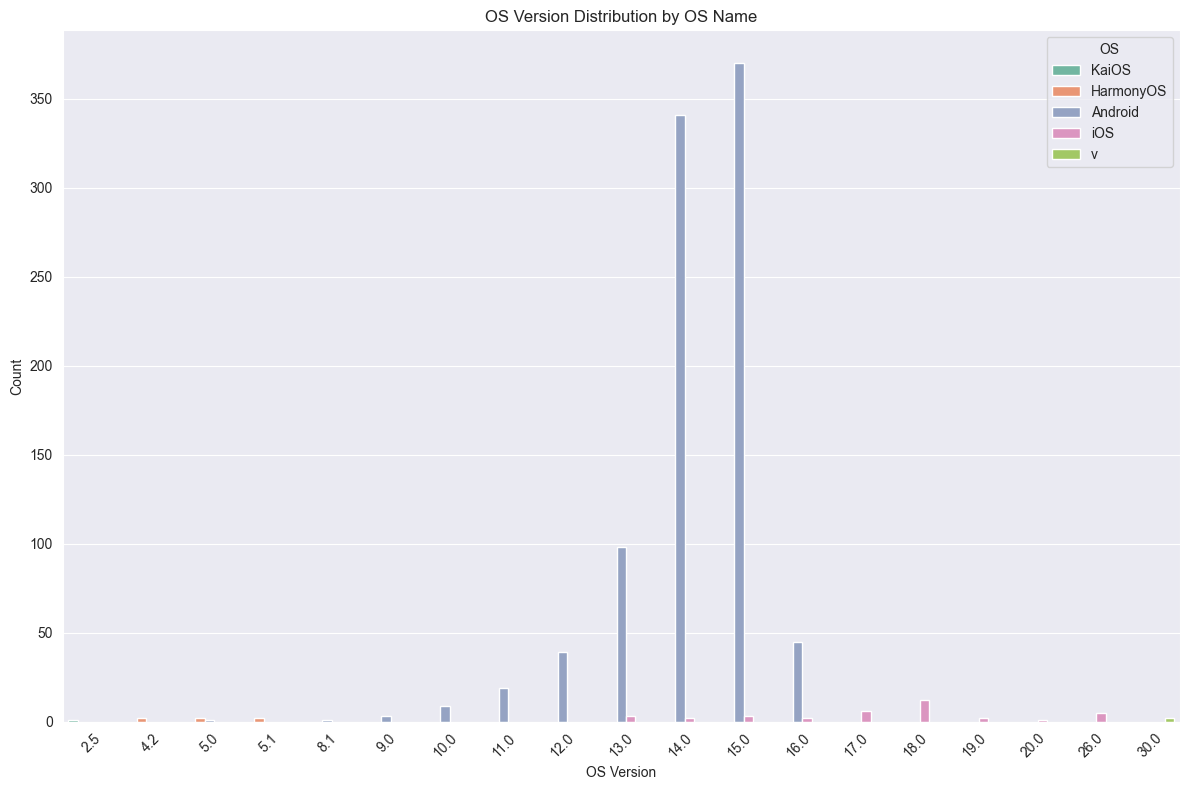

In [243]:
df_os = df[df['os_name'].notna() & df['os_version'].notna()].copy()

plt.figure(figsize=(12, 8))

# Plot the amount of OS version per OS type
sns.countplot(
    data=df_os,
    x='os_version',
    hue='os_name',
    palette='Set2'
)

plt.title('OS Version Distribution by OS Name')
plt.xlabel('OS Version')
plt.ylabel('Count')
plt.legend(title='OS')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Android appears to be the most popular OS on the market, specifically versions 14 and 15.

Extracts RAM and internal storage sizes from the **storage** description. RAM is parsed in GB, and internal storage is converted to GB, handling both GB and TB units.

In [244]:
df['storage'] = df['storage'].fillna('').str.lower()

df['ram_gb'] = df['storage'].str.extract(r'(\d+)\s*gb\s*ram').astype(float)

storage_match = df['storage'].str.extract(r',\s*(\d+)\s*(gb|tb)\s*inbuilt')

df['storage_gb'] = storage_match.apply(
    lambda row: float(row[0]) * (1024 if row[1] == 'tb' else 1) if pd.notnull(row[0]) else None,
    axis=1
)

Visualizing the distribution of RAM sizes and internal storage capacities across phones using histograms with kernel density estimates.

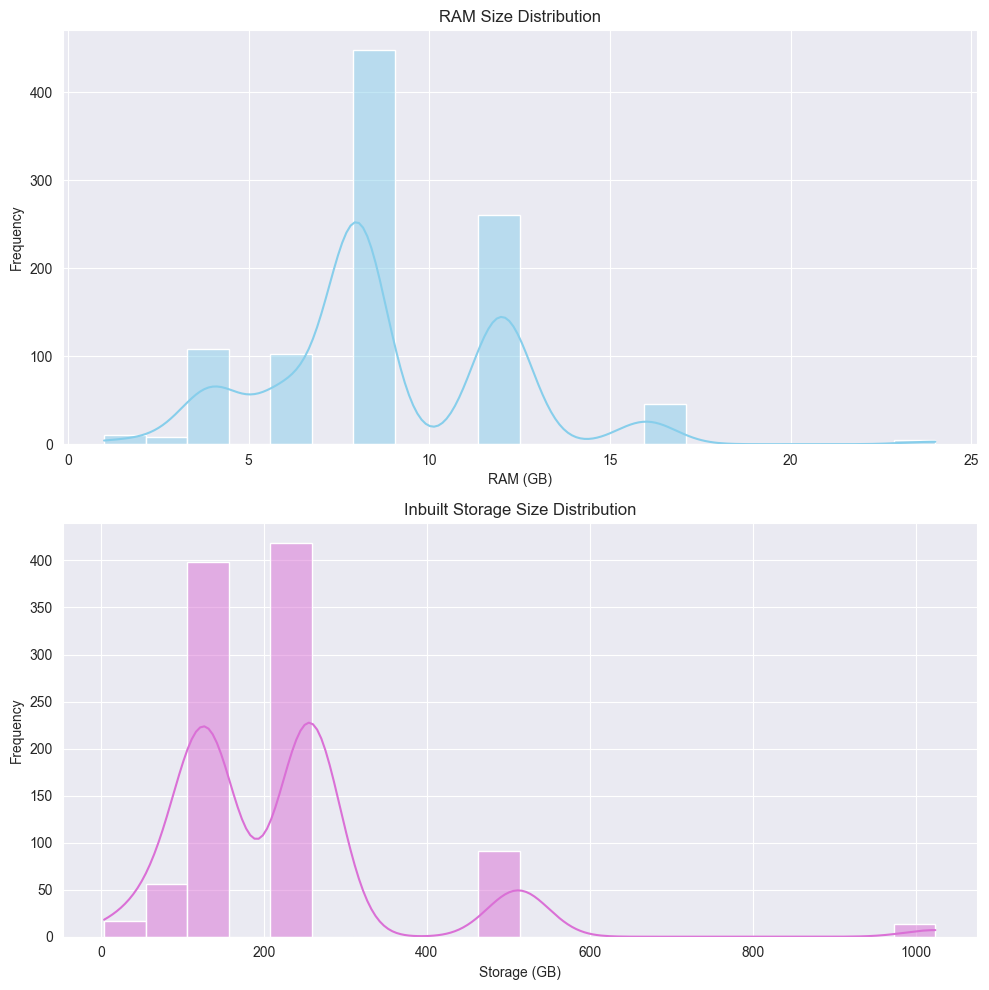

In [245]:
# Plot the varying RAM distributions
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
sns.histplot(df['ram_gb'].dropna(), bins=20, kde=True, color='skyblue')
plt.title('RAM Size Distribution')
plt.xlabel('RAM (GB)')
plt.ylabel('Frequency')

# Plot the varying Inbuilt Storage distribution
plt.subplot(2, 1, 2)
sns.histplot(df['storage_gb'].dropna(), bins=20, kde=True, color='orchid')
plt.title('Inbuilt Storage Size Distribution')
plt.xlabel('Storage (GB)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

- Most phones appear to have ~8 GB RAM with a good amount also having ~12 GB
- Inbuilt storage appears to be ~ 128 GB and ~ 256 GB

Assumes that null means FM Radio is supported due to 'No FM Radio' being the only value in the **fm** column.

In [246]:
df['fm_supported'] = df['fm'].isna()

Compares the amount of phones that support FM Radio to those that don't.

<Figure size 1000x1000 with 0 Axes>

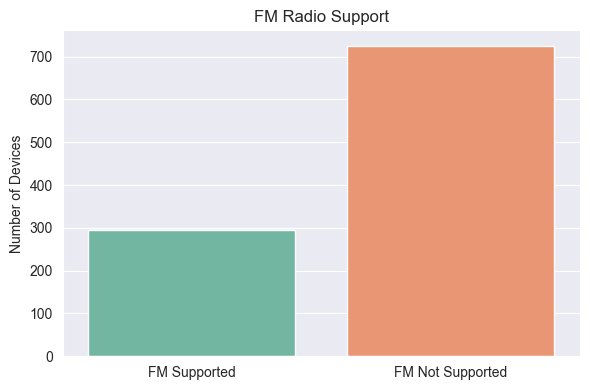

In [247]:
plt.figure(figsize=(10, 10))
fm_counts = df['fm_supported'].value_counts().sort_index()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(
    x=fm_counts.index.map({False: 'FM Supported', True: 'FM Not Supported'}),
    y=fm_counts.values,
    hue=fm_counts.index.map({False: 'FM Supported', True: 'FM Not Supported'}),
    palette="Set2",
    legend=False
)

plt.title('FM Radio Support')
plt.ylabel('Number of Devices')
plt.xlabel('')

plt.tight_layout()
plt.show()

- Most phones do **_NOT_** support FM Radio

Plots the distributions of **Spec Score**, **Rating**, and **Price**.

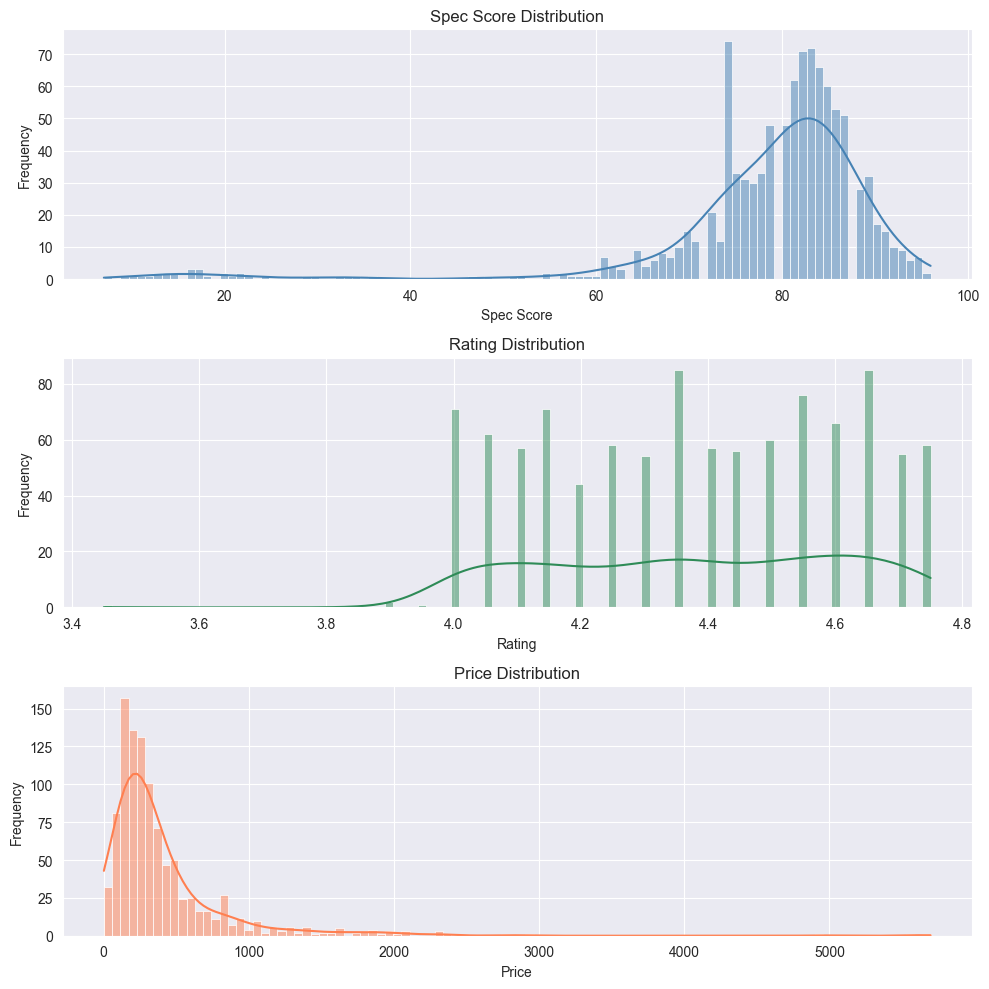

In [249]:
plt.figure(figsize=(10, 10))

# Spec Score histogram
plt.subplot(3, 1, 1)
sns.histplot(df['spec score'].dropna(), bins=100, kde=True, color='steelblue')
plt.title('Spec Score Distribution')
plt.xlabel('Spec Score')
plt.ylabel('Frequency')

# Rating histogram
plt.subplot(3, 1, 2)
sns.histplot(df['rating'].dropna(), bins=100, kde=True, color='seagreen')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# Price histogram
plt.subplot(3, 1, 3)
sns.histplot(df['price_usd'].dropna(), bins=100, kde=True, color='coral')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

- Spec Scores are left tailed, leaning towards the upper end and indicating outliers
- Rating appear to be evenly distributed between 4-4.8, but left tailed and indicating outliers
- Prices appear to mainly be around 100-500 USD but heavily right tailed, indicating outliers

Plots a polynomial relationship of degree 9 between **Spec Score** and **price**.

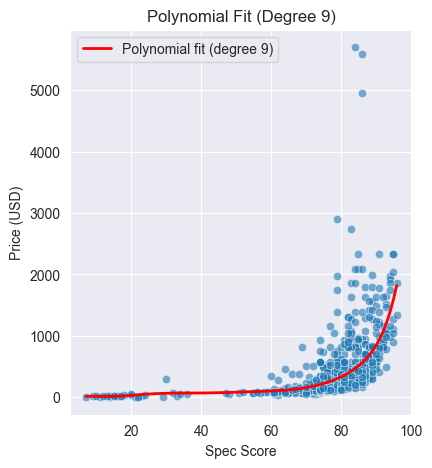

In [250]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 2)
sns.scatterplot(data=df, x='spec score', y='price_usd', alpha=0.6)
x_smooth = np.linspace(x_clean.min(), x_clean.max(), 100)

poly_coeffs_5 = np.polyfit(x_clean, y_clean, 9)
y_poly_5 = np.polyval(poly_coeffs_5, x_smooth)

plt.plot(x_smooth, y_poly_5, 'red', linewidth=2, label='Polynomial fit (degree 9)')
plt.title('Polynomial Fit (Degree 9)')
plt.xlabel('Spec Score')
plt.ylabel('Price (USD)')
plt.legend()

Displays all columns existing after parsing.

In [252]:
print(df.columns)

Index(['Name', 'Spec Score', 'rating', 'price', 'sim', 'processor', 'storage',
       'battery', 'display', 'camera', 'memoryExternal', 'version', 'fm',
       'brand', 'no_sim', 'is_dual_sim', 'has_3g', 'has_4g', 'has_5g',
       'has_volte', 'has_vo5g', 'has_wifi', 'has_nfc', 'has_ir_blaster',
       'processor_brand', 'processor_speed_ghz', 'core_count',
       'battery_capacity_mah', 'charging_speed_w', 'screen_size_inches',
       'resolution', 'refresh_rate_hz', 'display_type', 'rear_mp_list',
       'rear_mp_total', 'rear_lens_count', 'rear_lens_word',
       'rear_lens_word_count', 'front_mp', 'external_memory_gb',
       'external_memory_supported', 'external_memory_gb_filled', 'os_name',
       'os_version', 'ram_gb', 'storage_gb', 'fm_supported', 'spec score',
       'price_usd'],
      dtype='object')


This function takes a pandas Series of listsand extracts summary statistics (count, sum, mean, min, max, std) for each list. It safely handles empty or invalid data and returns a new DataFrame with the calculated features prefixed by the original Series name.

In [253]:
def extract_list_features(series):
    def safe_stats(lst):
        if not lst or len(lst) == 0:
            return {
                'count': 0,
                'sum': np.nan,
                'mean': np.nan,
                'min': np.nan,
                'max': np.nan,
                'std': np.nan,
            }
        try:
            arr = np.array(lst).astype(float)
            return {
                'count': len(arr),
                'sum': np.sum(arr),
                'mean': np.mean(arr),
                'min': np.min(arr),
                'max': np.max(arr),
                'std': np.std(arr),
            }
        except:
            return {
                'count': len(lst),
                'sum': np.nan,
                'mean': np.nan,
                'min': np.nan,
                'max': np.nan,
                'std': np.nan,
            }
    features_df = series.apply(safe_stats).apply(pd.Series)
    features_df.columns = [f"{series.name}_{col}" for col in features_df.columns]
    return features_df

Filters out price outliers using IQR, splits the data into training and test sets, fits a 9th-degree polynomial to predict phone price based on spec score, and evaluates performance using MAE, RMSE, and R² metrics.

In [254]:
df_clean = df[['spec score', 'price_usd']].dropna()

Q1 = df_clean['price_usd'].quantile(0.25)
Q3 = df_clean['price_usd'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean = df_clean[(df_clean['price_usd'] >= lower_bound) & (df_clean['price_usd'] <= upper_bound)]

x = df_clean['spec score'].values
y = df_clean['price_usd'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

poly_coeffs = np.polyfit(x_train, y_train, 9)

# Predict
y_pred = np.polyval(poly_coeffs, x_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

MAE: 95.87
RMSE: 140.13
R²: 0.470


Plot to visualize the results.

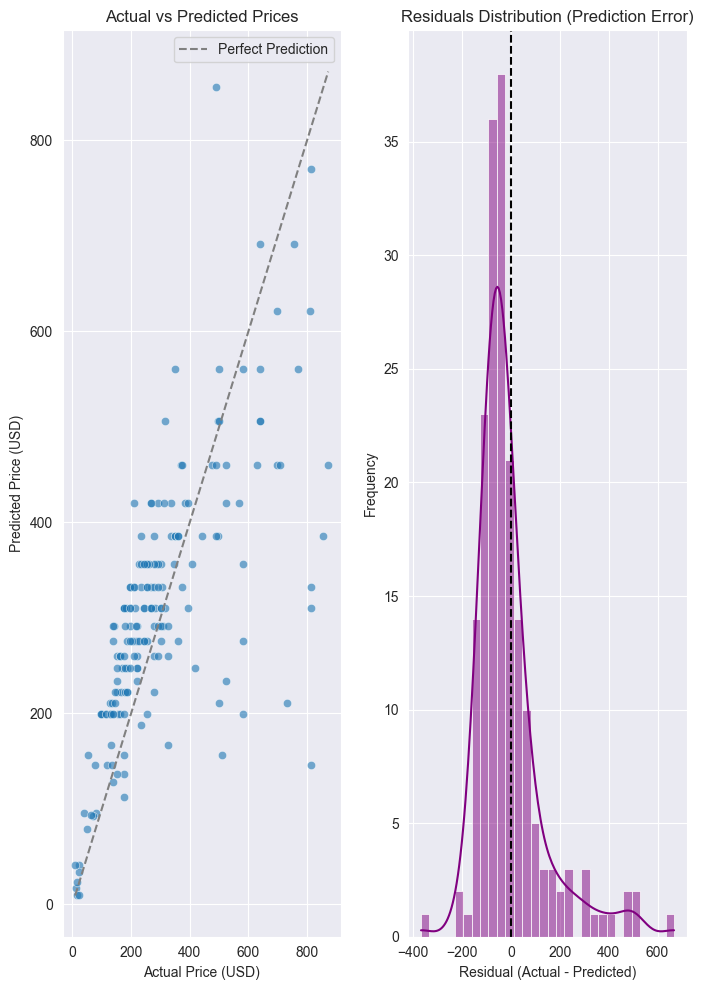

In [255]:
# 1. Fit line on full data
x_smooth = np.linspace(x_clean.min(), x_clean.max(), 100)
y_smooth = np.polyval(poly_coeffs, x_smooth)

plt.figure(figsize=(10, 10))
# Plot 2: Residuals Scatterplot
plt.subplot(1, 3, 2)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='gray', label='Perfect Prediction')
plt.xlabel("Actual Price (USD)")
plt.ylabel("Predicted Price (USD)")
plt.title("Actual vs Predicted Prices")
plt.legend()

# Plot 3: Residuals Histogram
residuals = y_test - y_pred
plt.subplot(1, 3, 3)
sns.histplot(residuals, bins=30, kde=True, color='purple')
plt.axvline(0, color='black', linestyle='--')
plt.title("Residuals Distribution (Prediction Error)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


Result indicate moderate performance that can be improved.

Code prepares features developed through prior parsing, removes price outliers, extracts stats from list-type columns, preprocesses data, and trains a Random Forest model to predict phone prices. It then evaluates the model using MAE, RMSE, and R².

In [282]:
features = [
    'brand', 'no_sim', 'is_dual_sim', 'has_3g', 'has_4g', 'has_5g',
    'has_volte', 'has_vo5g', 'has_wifi', 'has_nfc', 'has_ir_blaster',
    'processor_brand', 'processor_speed_ghz', 'core_count',
    'battery_capacity_mah', 'charging_speed_w', 'screen_size_inches',
    'resolution', 'refresh_rate_hz', 'display_type', 'rear_mp_list',
    'rear_mp_total', 'rear_lens_count', 'rear_lens_word',
    'rear_lens_word_count', 'front_mp', 'external_memory_gb',
    'external_memory_supported', 'external_memory_gb_filled', 'os_name',
    'os_version', 'ram_gb', 'storage_gb', 'fm_supported', 'spec score',
    'rating'
]

df_model = df[features + ['price_usd']].copy()
df_model = df_model.dropna(subset=['price_usd'])
Q1 = df_model['price_usd'].quantile(0.25)
Q3 = df_model['price_usd'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_model = df_model[(df_model['price_usd'] >= lower_bound) & (df_model['price_usd'] <= upper_bound)]

list_cols = [col for col in df_model.columns if df_model[col].apply(lambda x: isinstance(x, list)).any()]
for col in list_cols:
    extracted = extract_list_features(df_model[col])
    df_model = pd.concat([df_model, extracted], axis=1)
    df_model.drop(columns=[col], inplace=True)

new_features = []
for col in features:
    if col in list_cols:
        new_features.extend([c for c in df_model.columns if c.startswith(col + '_')])
    else:
        new_features.append(col)

X = df_model[new_features]
y = df_model['price_usd']

categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_estimators=100))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.3f}")

MAE: 49.68
RMSE: 91.18
R²: 0.776


Plot to visualize the results.

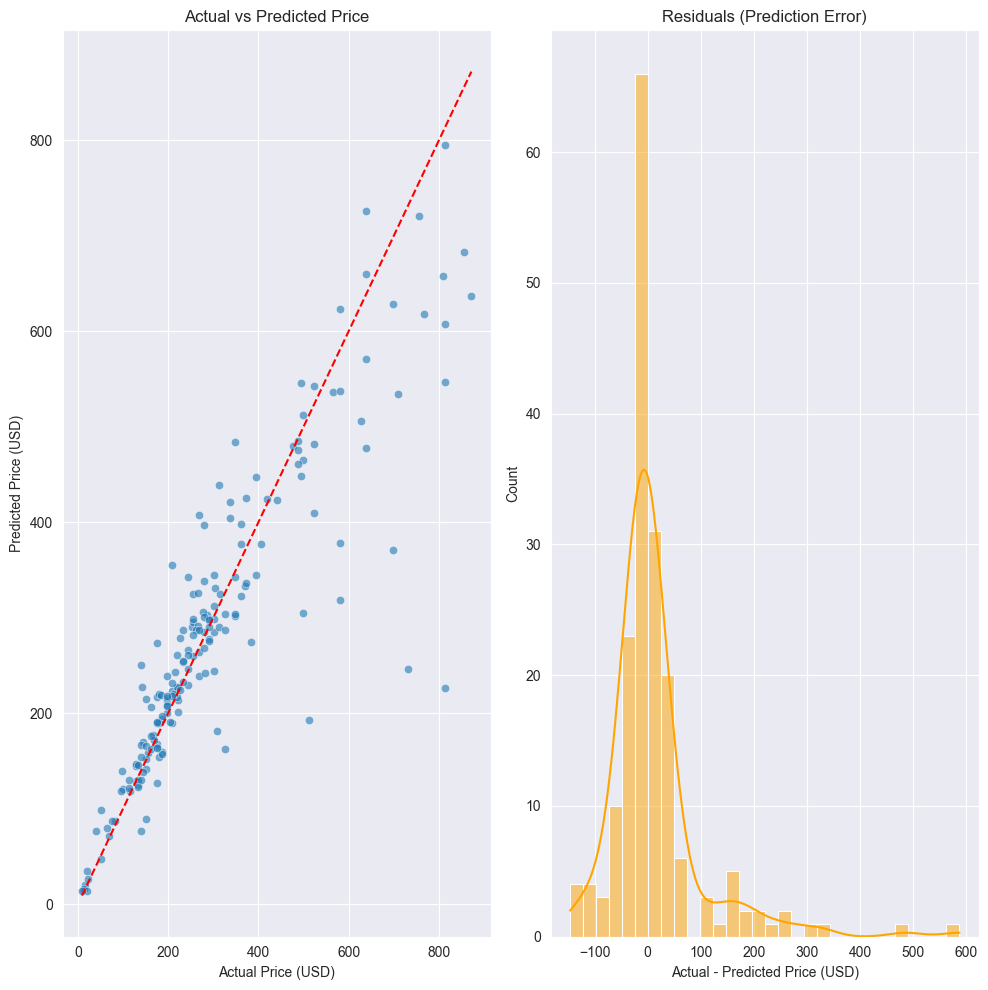

In [281]:
plt.figure(figsize=(10, 10))

# 1. Actual vs Predicted
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual Price (USD)")
plt.ylabel("Predicted Price (USD)")
plt.title("Actual vs Predicted Price")

# 2. Residuals
plt.subplot(1, 2, 2)
residuals = y_test - y_pred
sns.histplot(residuals, bins=30, kde=True, color='orange')
plt.title("Residuals (Prediction Error)")
plt.xlabel("Actual - Predicted Price (USD)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

Results indicate strong improvement from using just **Spec Score** but still has room for improvement.

Heatmap to determine what features impacted the model the most.

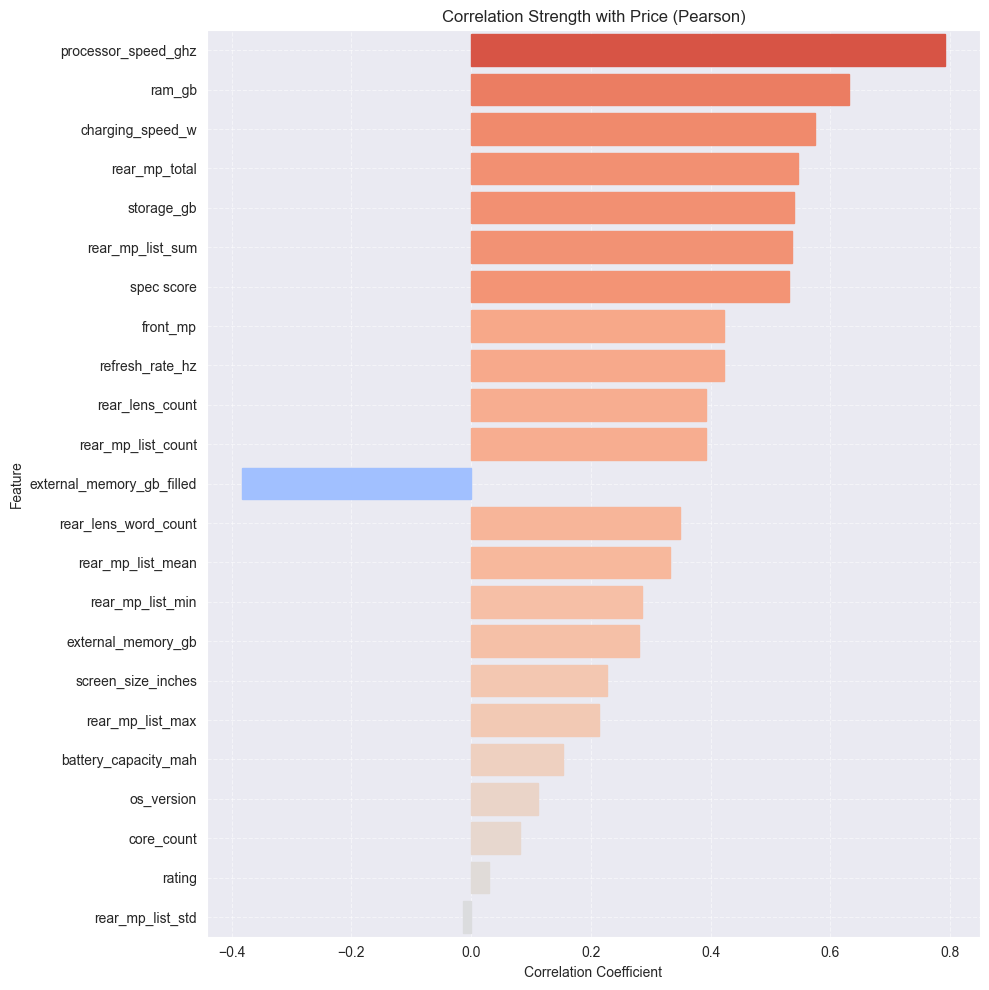

In [263]:
plt.figure(figsize=(10, 10))

norm_corr = (price_corr.values + 1) / 2

colors = sns.color_palette("coolwarm", as_cmap=True)(norm_corr)

barplot = sns.barplot(x=price_corr.values, y=price_corr.index, color='gray')

for bar, color in zip(barplot.patches, colors):
    bar.set_color(color)

plt.title('Correlation Strength with Price (Pearson)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


- The features that impacted the model the most were mainly hardware components
- Missing data in some columns may affect deeper analysis.